In [1]:
import sqlite3
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the embedding data from the unshuffled sequences
# ids are in ruseq.txt
conn = sqlite3.connect('../uniref90-10pm.db')
c = conn.cursor()

# get the embeddings
embeddings_unshuff = []
with open('ruseq10000.txt') as f:
    keys = f.read().splitlines()

for key in keys:
    c.execute('SELECT embedding FROM uniref90 WHERE name = ?', (key,))
    embedding = c.fetchone()[0]
    if np.frombuffer(embedding, dtype=np.float16).shape[0] != 1024:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float32))
    else:
        embeddings_unshuff.append(np.frombuffer(embedding, dtype=np.float16))

conn.close()

In [3]:
embeddings_unshuff = np.array(embeddings_unshuff)

In [4]:
# load the shuffled sequences
# embedding data is in rss.h5

embeddings_shuff = []

with h5py.File('rss10000.h5', 'r') as f:
    for key in f.keys():
        embeddings_shuff.append(f[key][:])

print(np.array(embeddings_shuff).shape)
embeddings_shuff = np.array(embeddings_shuff)

(10000, 1024)


In [5]:
import pandas as pd

# read third party embeddings from the tsv file
df = pd.read_csv('../rg/sfiltered_nonredundant.tsv', sep='\t')
df1 = pd.read_csv('../rg/filtered_nonredundant.tsv', sep='\t')

# get the euclid sim and cosine sim from the columns
# euclid_sim = df['embdd_eucld'].values
cos_sim = df['embdd_cos'].values
# euclid_sim1 = df1['embdd_eucld'].values
cos_sim1 = df1['embdd_cos'].values

In [6]:
# plot the norms of the embeddings on a histogram and a boxplot on the same plot

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plt.suptitle('Norm of embeddings, unshuffled vs shuffled')
# ax[0].hist(np.linalg.norm(embeddings_unshuff, axis=1), bins=100, alpha=0.5, label='UniRef90')
# ax[0].hist(np.linalg.norm(embeddings_shuff, axis=1), bins=100, alpha=0.5, label='shuffled')
# ax[0].set_title('Histogram of norms')
# ax[0].set_ylabel('Frequency')
# ax[0].set_xlabel('Norm')
# ax[0].legend()

# ax[1].boxplot([np.linalg.norm(embeddings_unshuff, axis=1), np.linalg.norm(embeddings_shuff, axis=1)], labels=['UniRef90', 'shuffled'])
# ax[1].set_title('Boxplot of norms')
# ax[1].set_ylabel('Norm')
# ax[1].set_xlabel('Dataset')

# plt.show()

In [7]:
# plot histograms of the embeddings euclidean similarities for unshuff - unshuff pairs and unshuff - shuff pairs
# euclidean sim is 0.5 / (0.5 + euclidean distance)

# from scipy.spatial.distance import euclidean
import tqdm as tqdm

# def euclidean_sim(a, b):
#     return 0.5 / (0.5 + euclidean(a, b))

# # unshuff - unshuff
# sims_unshuff = []
# sims_shuff = []
# for i in tqdm.tqdm(range(embeddings_unshuff.shape[0]), total=embeddings_unshuff.shape[0]):
#     for j in range(i+1, embeddings_unshuff.shape[0]):
#         sims_unshuff.append(euclidean_sim(embeddings_unshuff[i], embeddings_unshuff[j]))
#         sims_shuff.append(euclidean_sim(embeddings_unshuff[i], embeddings_shuff[j]))

# plt.hist(sims_unshuff, bins=100, alpha=0.5, label='unshuff - unshuff')
# plt.hist(sims_shuff, bins=100, alpha=0.5, label='unshuff - shuff')
# plt.legend()
# plt.show()

In [8]:
# print unsuff - unshuff mean and std
# print(np.mean(sims_unshuff), np.std(sims_unshuff))

In [9]:
# do a t-test to see if the two distributions are different

# from scipy.stats import ttest_ind

# t, p = ttest_ind(sims_unshuff, sims_shuff)
# print(t, p)

In [10]:
# cosine similarity
# from sklearn.metrics.pairwise import cosine_similarity as cosine
import numpy as np
from numpy.linalg import norm

# unshuff - unshuff
sims_unshuff1 = []
sims_shuff1 = []
for i in tqdm.tqdm(range(embeddings_unshuff.shape[0]), total=embeddings_unshuff.shape[0]):
    for j in range(i+1, embeddings_unshuff.shape[0]):
        sims_unshuff1.append(np.dot(embeddings_unshuff[i], embeddings_unshuff[j]) / (norm(embeddings_unshuff[i]) * norm(embeddings_unshuff[j])))
        sims_shuff1.append(np.dot(embeddings_unshuff[i], embeddings_shuff[j]) / (norm(embeddings_unshuff[i]) * norm(embeddings_shuff[j])))
        # sims_unshuff1.append(cosine(embeddings_unshuff[i].reshape(1, -1), embeddings_unshuff[j].reshape(1, -1))[0][0])
        # sims_shuff1.append(cosine(embeddings_unshuff[i].reshape(1, -1), embeddings_shuff[j].reshape(1, -1))[0][0])

# plt.hist(sims_unshuff1, bins=100, alpha=0.5, label='unshuff - unshuff')
# plt.hist(sims_shuff1, bins=100, alpha=0.5, label='unshuff - shuff')
# plt.legend()
# plt.show()

100%|██████████| 10000/10000 [11:55<00:00, 13.98it/s]


In [ ]:
# find the cutoff where in the total data above the cutoff is 95% of the unshuffle - unshuff similarity and at most 5% of the unshuff - shuff similarity
# sort the similarities
sims_unshuff1 = np.array(sims_unshuff1)
sims_shuff1 = np.array(sims_shuff1)

# sort the similarities
sims_unshuff1.sort()
sims_shuff1.sort()

# find the cutoff by trying a random value first then adjusting
cutoff = 0
threshold = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# while True:
#     total = np.sum(sims_unshuff1 >= cutoff) + np.sum(sims_shuff1 >= cutoff)
#     if np.sum(sims_unshuff1 >= cutoff) / total >= (1 - threshold) and np.sum(sims_shuff1 >= cutoff) / total <= threshold:
#         break
#     else:
#         cutoff += 0.01

print('Cutoff:', cutoff)
print(total)
print('Unshuff - unshuff:', np.sum(sims_unshuff1 >= cutoff) / total, 'Unshuff - shuff:', np.sum(sims_shuff1 >= cutoff) / total)
print('counts:', np.sum(sims_unshuff1 >= cutoff), np.sum(sims_shuff1 >= cutoff))

Cutoff: 0.7700000000000005
21612
Unshuff - unshuff: 0.9516472330186934 Unshuff - shuff: 0.04835276698130668
counts: 20567 1045


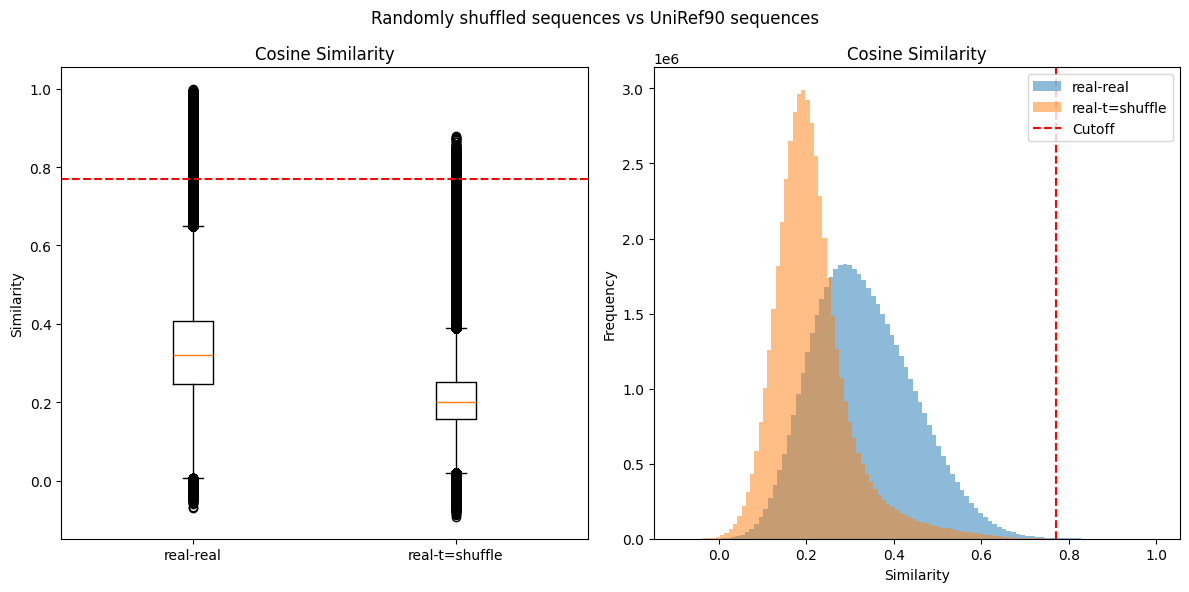

In [14]:
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create 1x3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1x3 subplots

fig.suptitle('Randomly shuffled sequences vs UniRef90 sequences')

# axs[0].boxplot([sims_shuff, sims_unshuff, euclid_sim, euclid_sim1], labels=['unshuff - shuff', 'unshuff - unshuff', 'praba-same-F', 'praba-diff-F'])
# axs[0].set_title('Euclidean Similarity')
# axs[0].set_ylabel('Similarity')

# axs[1].hist(sims_unshuff, bins=100, alpha=0.5, label='unshuff - unshuff')
# axs[1].hist(sims_shuff, bins=100, alpha=0.5, label='unshuff - shuff')
# axs[1].hist(euclid_sim, bins=100, alpha=0.5, label='praba-same-F')
# axs[1].hist(euclid_sim1, bins=100, alpha=0.5, label='praba-diff-F')
# axs[1].set_title('Euclidean Similarity')
# axs[1].legend(loc='upper right')
# axs[1].set_xlabel('Similarity')
# axs[1].set_ylabel('Frequency')

# axs[0].boxplot([sims_shuff1, sims_unshuff1, cos_sim, cos_sim1], labels=['unshuff - shuff', 'unshuff - unshuff', 'praba-sim', 'praba-diff'])
axs[0].boxplot([sims_unshuff1, sims_shuff1], labels=['real-real', 'real-t=shuffle'])
# print cutoff line
axs[0].axhline(y=cutoff, color='r', linestyle='--', label='Cutoff')
axs[0].set_title('Cosine Similarity')
axs[0].set_ylabel('Similarity')

# axs[2].hist(sims_unshuff1, bins=100, alpha=0.5, label='unshuff - unshuff')
# axs[2].hist(sims_shuff1, bins=100, alpha=0.5, label='unshuff - shuff')
# axs[2].hist(cos_sim, bins=100, alpha=0.5, label='praba-sim')
# axs[2].hist(cos_sim1, bins=100, alpha=0.5, label='praba-diff')
# axs[2].set_title('Cosine Similarity')
# axs[2].legend(loc='upper right')
# axs[2].set_xlabel('Similarity')
# axs[2].set_ylabel('Frequency')

axs[1].hist(sims_unshuff1, bins=100, alpha=0.5, label='real-real')
axs[1].hist(sims_shuff1, bins=100, alpha=0.5, label='real-t=shuffle')
# axs[1].hist(cos_sim, bins=100, alpha=0.5, label='praba-sim')
# axs[1].hist(cos_sim1, bins=100, alpha=0.5, label='praba-diff')
# plot cutoff line
axs[1].axvline(x=cutoff, color='r', linestyle='--', label='Cutoff')
axs[1].set_title('Cosine Similarity')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()